In [41]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
from pprint import pprint
from citeline.database.milvusdb import MilvusDB
from citeline.embedders import Embedder
from citeline.query_expander import QueryExpander

db = MilvusDB()
print(db)

tqdm.pandas()

# Setup: load embedder, expander, dataset, db collection
embedder = Embedder.create("Qwen/Qwen3-Embedding-0.6B", device="mps", normalize=True)
print(embedder)

expander = QueryExpander("add_prev_3", reference_data_path="../data/preprocessed/reviews.jsonl")
print(expander)

sample = pd.read_json("../data/dataset/nontrivial_100.jsonl", lines=True)
# sample = sample.sample(96, random_state=42).reset_index(drop=True)

# Apply query expansion and embed the queries
sample["sent_no_cit"] = expander(sample)
sample["vector"] = sample.progress_apply(lambda row: embedder([row["sent_no_cit"]])[0], axis=1)

db.list_collections()
# db.client.load_collection("qwen06_contributions")
db.client.load_collection("qwen06_chunks")

sample.head()

Qwen/Qwen3-Embedding-0.6B, device=mps, normalize=True, dim=1024
QueryExpander(name=add_prev_3, data_length=2980)


100%|██████████| 100/100 [00:09<00:00, 11.01it/s]


Collections:
 - astrobert_chunks: 460801 entities
 - astrobert_contributions: 89860 entities
 - bge_chunks: 460801 entities
 - bge_contributions: 89860 entities
 - nasa_chunks: 460801 entities
 - nasa_contributions: 89860 entities
 - qwen06_chunks: 460801 entities
 - qwen06_contributions: 89860 entities
 - qwen06_findings_v2: 4342 entities
 - qwen06_v3_contributions: 299286 entities
 - qwen8b_contributions: 89860 entities
 - specter_chunks: 460801 entities
 - specter_contributions: 89860 entities


,source_doi,sent_original,sent_no_cit,sent_idx,citation_dois,pubdate,resolved_bibcodes,sent_cit_masked,vector
0,10.1007/s00159-008-0010-0,"(Shang et al. 1998), do show unusual, faint fe...",Such events 123 196 R. Sancisi et al. are more...,159,[10.1086/311563],20080601,[1998ApJ...504L..23S],"([REF]), do show unusual, faint features in th...","[0.019467777, -0.050828665, -0.009596894, 0.01..."
1,10.1016/j.newar.2004.03.017,Novak et al. (2003) studied the dust emission ...,The radio emission shows that the nonthermal e...,1329,[10.1086/368156],20040901,[2003ApJ...583L..83N],[REF] studied the dust emission at 450 μm in t...,"[0.0020762016, 0.016566603, -0.0056969826, 0.0..."
2,10.1146/annurev-astro-091918-104430,The momentum per unit mass of stars formed del...,There has yet to be a comprehensive numerical ...,542,[10.1086/317785],20190801,[2000ApJ...545..364M],The momentum per unit mass of stars formed del...,"[0.040522993, -0.03144786, -0.010288201, 0.010..."
3,10.1146/annurev-astro-081309-130834,An example of the latter is the dormant blue s...,Because the observed YMCs will age to become o...,815,[10.48550/arXiv.astro-ph/9701042],20100901,[1997A&A...328..130P],An example of the latter is the dormant blue s...,"[-0.02477378, -0.02790011, -0.013496099, 0.052..."
4,10.1146/annurev.astro.37.1.127,Kaiser et al (1995) (see also Luppino Kaiser 1...,The anisotropy of the PSF is corrected on the ...,282,"[10.1086/176071, 10.1086/303508, 10.1086/306102]",19990101,"[1995ApJ...449..460K, 1997ApJ...475...20L, 199...",[REF] (see also [REF] for further developments...,"[0.032639474, -0.07257655, -0.009156834, 0.008..."


In [42]:
def get_hard_records(example: pd.Series, n: int = 2) -> list[str]:
    """
    Overfetches 3*n most similar records (bc if two reps from same doc are in top n, we won't have n distinct non-target dois)

    Returns:
      A list of doi's, ordered by their max similarity to the query
    """
    results = db.search(
        collection_name="qwen06_contributions",
        query_records=[example.to_dict()],
        query_vectors=[example.vector],
        limit=10 * n,
    )
    results = results[0]  # db.search operates on lists of queries; we only need the first result

    # Filter results to non-targets only
    target_dois = set(example.citation_dois)
    non_target_results = [r for r in results if r["doi"] not in target_dois]
    return non_target_results[:n]


def get_similarity_to_targets(example: pd.Series) -> list[float]:
    """
    For each target doi in the example, computes the max similarity between the example and any record with that doi.

    Returns a list of scores in order of example.citation_dois
    """
    similarities = []
    for target_doi in example.citation_dois:
        try:
            results = db.select_by_doi(doi=target_doi, collection_name="qwen06_chunks")
            target_vectors = np.array(results["vector"].tolist())
            similarity_scores = np.dot(example.vector, target_vectors.T)
            similarities.append(np.max(similarity_scores))
        except Exception as e:
            print(f"Error processing DOI {target_doi}: {e}")
    return similarities


def compute_margins(df: pd.DataFrame, target_col: str, hard_col: str, margin_col_name: str) -> None:
    """
    For each row in the DataFrame, computes the margin between each target similarity and the hardest non-target similarity.

    Args:
      df: DataFrame containing the data
      target_col: Name of the column with list of target similarities
      hard_col: Name of the column with list of hard non-target similarities
      margin_col_name: Name of the column to store the computed margins

    Returns:
      None (modifies df in place)
    """

    df[margin_col_name] = None
    for idx, row in df.iterrows():
        target_similarities = row[target_col]
        hardest_nontarget_similarity = max(row[hard_col])
        margins = [target_sim - hardest_nontarget_similarity for target_sim in target_similarities]
        df.at[idx, margin_col_name] = margins


# Compute target and hard similarities, then the margins
sample["target_similarities"] = sample.progress_apply(get_similarity_to_targets, axis=1)
sample["hard_dois"] = None
sample["hard_similarities"] = None
for idx, example in tqdm(sample.iterrows(), total=len(sample)):
    hard_records = get_hard_records(example, n=2)
    sample.at[idx, "hard_dois"] = [r["doi"] for r in hard_records]
    sample.at[idx, "hard_similarities"] = [r["metric"] for r in hard_records]

compute_margins(sample, target_col="target_similarities", hard_col="hard_similarities", margin_col_name="old_margins")

100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


In [43]:
margins = pd.to_numeric(sample.explode(column="old_margins")["old_margins"], errors="coerce").dropna()
margins.describe()

count    131.000000
mean      -0.017117
std        0.083036
min       -0.249376
25%       -0.058822
50%       -0.013357
75%        0.040393
max        0.177340
Name: old_margins, dtype: float64

In [44]:
for stat, num in margins.describe().items():
    print(f"{num:.4f}")

131.0000
-0.0171
0.0830
-0.2494
-0.0588
-0.0134
0.0404
0.1773


In [45]:
margins.to_pickle("margins_chunks_n100.pkl")

## Process the dois


In [46]:
dois_to_process = set(doi for dois in sample.citation_dois for doi in dois).union(
    doi for dois in sample.hard_dois for doi in dois
)
print(f"DOI's to process: {len(dois_to_process)}")

# Load research papers so we can get full text by doi
research = pd.read_json("../data/research_used.jsonl", lines=True)
research = research[research["doi"].isin(dois_to_process)].reset_index(drop=True)
print(f"Loaded {len(research)} research papers")


def doi_to_paper(doi: str) -> str:
    record = research[research["doi"] == doi].iloc[0]
    return record["title"] + "\n\n" + record["abstract"] + "\n\n" + record["body"]

DOI's to process: 309
Loaded 309 research papers


In [47]:
# DeepSeek client
from citeline.apis.deepseek import deepseek_formatted as deepseek


In [48]:
# OpenAI, Gemini Clients

# from citeline.apis.openai_client import openai_llm_client

# openai_llm = openai_llm_client(model="gpt-5-nano")


# from google import genai
# from google.genai import types
# from citeline.llm.models import Findings

# client = genai.Client()
# with open("../src/citeline/llm/prompts/original_contributions_gemini_v3.txt", "r") as f:
#     prompt_template = f.read()


# def gemini(paper: str) -> str:
#     raw_text = ""
#     try:
#         response = client.models.generate_content(
#             model="gemini-2.5-flash",
#             config=types.GenerateContentConfig(
#                 temperature=0.0,
#                 system_instruction=prompt_template,
#                 response_mime_type="application/json",
#                 response_schema=Findings,
#             ),
#             contents=paper,
#         )
#         return response.parsed
#     except Exception as e:
#         print(f"Error during Gemini call: {e}")
#         return ""

### Set the filename for this run's generated findings


In [49]:
doi_list = list(dois_to_process)

In [50]:
NEW_FINDINGS_FILENAME = "chunksums_v2_reasoner_n100.jsonl"
with open("../src/citeline/llm/prompts/chunk_summarization_prompt.txt", "r") as outfile:
    prompt_template = outfile.read()

In [51]:
# Check for existing progress
try:
    with open(NEW_FINDINGS_FILENAME, "r") as outfile:
        existing_data = [json.loads(line) for line in outfile]
    processed_dois = set(item['doi'] for item in existing_data)
    print(f"Resuming from {len(processed_dois)} processed DOI's.")
except FileNotFoundError:
    processed_dois = set()
    print("No existing progress found, starting fresh.")

model = "deepseek-reasoner"
with open(NEW_FINDINGS_FILENAME, "a") as outfile:
    for doi in tqdm(dois_to_process):
        if doi in processed_dois:
            continue  # Skip already processed DOI's
        chunks = db.select_by_doi(doi=doi, collection_name="qwen06_chunks")
        if len(chunks) == 0:
            print(f"No chunks found for DOI {doi}, skipping.")
            continue
        for chunk in chunks:
            prompt = prompt_template.format(chunk=chunk)

        try:
            response = deepseek(prompt, model=model)
        except Exception as e:
            print(f"Error processing DOI {doi}: {e}")
            with open('summary_errors.log', 'a') as log_file:
                log_file.write(f"DOI {doi}: {e}\n")
            continue

        try:
            data = json.loads(response)
            data['doi'] = doi
            outfile.write(json.dumps(data) + "\n")
        except json.JSONDecodeError as e:
            print(f"JSON decode error for DOI {doi}: {e}")
            with open('summary_errors.log', 'a') as log_file:
                log_file.write(f"DOI {doi}: JSON decode error: {e}\n")
            continue

Resuming from 1 processed DOI's.


100%|██████████| 309/309 [5:15:42<00:00, 61.30s/it]  


In [52]:
# Contributions processing loop

# Check if any dois have already been processed
# try:
#     with open(NEW_FINDINGS_FILENAME, "r") as f:
#         processed_dois = {json.loads(line)["doi"] for line in f if line.strip()}
#         dois_to_process -= processed_dois
#     print(f"Already processed {len(processed_dois)} DOI's.")
# except FileNotFoundError:
#     processed_dois = set()
#     print("No existing findings file found. Starting fresh.")

# with open(NEW_FINDINGS_FILENAME, "a") as f:
#     for doi in tqdm(dois_to_process):
#         paper = doi_to_paper(doi)
#         prompt = prompt_template.format(paper=paper)
#         try:
#             # response = llm_function(prompt)
#             response = deepseek(prompt, model="deepseek-reasoner")
#         except Exception as e:
#             print(f"Error processing doi {doi}: {e}")
#             continue
#         try:
#             data = json.loads(response)
#             data["doi"] = doi
#             f.write(json.dumps(data) + "\n")
#         except json.JSONDecodeError:
#             print(f"Failed to decode JSON for doi {doi}. Response was:\n{response}")
#             with open("failed_dois.txt", "a") as f_fail:
#                 f_fail.write(doi + "\n")
#             continue

In [59]:
new_findings = pd.read_json(NEW_FINDINGS_FILENAME, lines=True)
print(f"Loaded {len(new_findings)} new findings")

new_findings_exploded = new_findings.explode("summary")
new_findings_exploded["vector"] = embedder(new_findings_exploded["summary"].tolist()).tolist()
new_findings_exploded.head()

Loaded 309 new findings


,summary,doi,vector
0,The provided research text is minimal and does...,10.3847/1538-4357/836/1/49,"[-0.05428605526685715, -0.026050584390759468, ..."
1,The research text discusses the concept of ide...,10.1093/pasj/58.1.L11,"[-0.01844191364943981, -0.04883312061429024, -..."
2,The research text is comprised of the term 'id...,10.1111/j.1365-2966.2007.11606.x,"[0.004783484153449535, -0.04797166585922241, -..."
3,The research text 'id' does not contain suffic...,10.1093/mnras/214.3.379,"[0.009091942571103573, -0.03556659445166588, -..."
4,The research text focuses on the concept of 'i...,10.1093/mnras/stz243,"[-0.0057793185114860535, -0.04804154112935066,..."


In [60]:
# Get new similarity to target
sample["new_target_similarities"] = None
sample["new_hard_similarities"] = None


def get_vectors_by_doi(doi: str) -> np.ndarray:
    return np.array(new_findings_exploded[new_findings_exploded["doi"] == doi]["vector"].tolist())


for idx, row in sample.iterrows():
    # For each target doi, compute the max similarity wrt the new embeddings
    query_vector = row["vector"]
    new_similarities = []
    for target_doi in row["citation_dois"]:
        target_vectors = get_vectors_by_doi(target_doi)
        new_similarities.append(np.max(np.dot(query_vector, target_vectors.T)))
    sample.at[idx, "new_target_similarities"] = new_similarities

    # Collect all the hard vectors, compute the hard similarities
    new_hard_similarities = []
    for doi in row["hard_dois"]:
        candidate_vectors = get_vectors_by_doi(doi)
        new_hard_similarities.append(np.max(np.dot(query_vector, candidate_vectors.T)))
    sample.at[idx, "new_hard_similarities"] = new_hard_similarities

In [61]:
compute_margins(
    sample, target_col="new_target_similarities", hard_col="new_hard_similarities", margin_col_name="new_margins"
)

In [62]:
def compute_margin_diffs(df: pd.DataFrame, new_col: str, ref_col: str) -> pd.Series:
    new_values = df[new_col].explode().tolist()
    ref_values = df[ref_col].explode().tolist()
    diffs = [new - ref for new, ref in zip(new_values, ref_values)]
    return pd.Series(diffs)


diffs = compute_margin_diffs(sample, new_col="new_margins", ref_col="old_margins")
print(diffs.describe())

count    131.000000
mean       0.000156
std        0.091300
min       -0.209149
25%       -0.065771
50%       -0.006664
75%        0.065055
max        0.203129
dtype: float64


In [63]:
for stat, num in diffs.describe().items():
    print(f"{num:.4f}")

131.0000
0.0002
0.0913
-0.2091
-0.0658
-0.0067
0.0651
0.2031


In [64]:
diffs.to_pickle("margins_chunksum_reasoner_n100.pkl")

## Error analysis

Let's look at where the new margin is still negative (the target document vectors aren't as close to the query as the hard examples)


In [ ]:
error_rows = sample[sample["new_margins"].apply(lambda margins: any(margin < 0 for margin in margins))]
print(f"{len(error_rows)} rows have at least one negative new margin")

error_margins = pd.to_numeric(error_rows.explode(column="new_margins")["new_margins"], errors="coerce").dropna()
print(error_margins.describe())

In [ ]:
error_rows

In [ ]:
def analyze_error_row(idx: int) -> None:

    example = error_rows.loc[idx]
    margins = [round(float(margin), 4) for margin in example["new_margins"]]
    print(f"Margins: {margins}")
    print("Original sentence:")
    print(example["sent_original"])
    print("\nExpanded sentence:")
    print(example["sent_no_cit"] + "\n")

    hardest_idx = np.argmax(example["new_hard_similarities"])
    hard_doi = example["hard_dois"][hardest_idx]
    hard_findings = new_findings_exploded[new_findings_exploded["doi"] == hard_doi]
    hard_vectors = np.array(hard_findings["vector"].tolist())
    hard_similarities = np.dot(example["vector"], hard_vectors.T)
    hardest_indices = np.argsort(-hard_similarities)[:3]
    for idx in hardest_indices:
        print(f"Similarity: {hard_similarities[idx]:.4f}, DOI: {hard_findings.iloc[idx]['doi']}")
        pprint(hard_findings.iloc[idx]["findings"])
        print("-----")


def print_target_contributions(idx: int) -> None:
    row = error_rows.loc[idx]
    print("Original sentence:")
    print(row["sent_original"])

    target_dois = row["citation_dois"]
    print(f"Target DOIs: {target_dois}")
    target_records = {
        doi: new_findings_exploded[new_findings_exploded["doi"] == doi]["findings"] for doi in target_dois
    }
    pprint("Target findings:")
    for doi in target_records:
        print(f"DOI: {doi}")
        for i, finding in enumerate(target_records[doi]):
            print(f"{i}: {finding}")
        print("-----")


idx = 4

print_target_contributions(idx)
analyze_error_row(idx)

In [ ]:
doi = "10.1086/319733"
row = new_findings[new_findings["doi"] == doi].iloc[0]
target_texts = row["findings"]
target_vectors = embedder(target_texts)
query_vector = embedder(
    [
        "One of the most surprising observations to date are those of the narrow absorption lines in the quasar 3C 191, which show evidence for partial covering at a large distance (28 kpc) from the nucleus ( ); it is difficult to understand how the small clouds have maintained their integrity over the outflow timescale of ∼3 × 10 7 year."
    ]
)[0]

cosine_similarities = np.dot(query_vector, target_vectors.T)
tups = sorted(enumerate(cosine_similarities), key=lambda x: -x[1])
for i, sim in tups:
    print(f"Finding {i}: similarity {sim:.4f}")
print(cosine_similarities)

In [ ]:
target_vector = embedder(
    ["Cosmic microwave background (CMB) anisotropy measurements indicate flat " "universe geometry."]
)[0]
# query_vector = error_rows.iloc[0]["vector"]
query_vector = embedder(
    [
        "This data provided the most convincing evidence then available for the Euclidean nature of the Universe; i.e. that the geometry is flat Fig. 16 The first measurement of polarization made of the CMBR, obtained by the DASI experiment at the South Pole "
    ]
)[0]
print(f"Cosine similarity: {query_vector.dot(target_vector):.4f}")

### Revision 2


In [ ]:
with open("../src/citeline/llm/prompts/original_contributions_v2.txt", "r") as outfile:
    prompt_template = outfile.read()

NEW_FINDINGS_FILENAME = "new_findings_v2.jsonl"

with open(NEW_FINDINGS_FILENAME, "w") as outfile:
    for doi in tqdm(dois_to_process):
        paper = doi_to_paper(doi)
        prompt = prompt_template.format(paper=paper)
        try:
            response = deepseek(prompt)
        except Exception as e:
            print(f"Error processing doi {doi}: {e}")
            continue
        try:
            data = json.loads(response)
            data["doi"] = doi
            outfile.write(json.dumps(data) + "\n")
        except json.JSONDecodeError:
            print(f"Failed to decode JSON for doi {doi}. Response was:\n{response}")
            with open("failed_dois.txt", "a") as f_fail:
                f_fail.write(doi + "\n")
            continue

In [ ]:
new_findings = pd.read_json(NEW_FINDINGS_FILENAME, lines=True)
print(f"Loaded {len(new_findings)} new findings")

new_findings_exploded = new_findings.explode("findings")
new_findings_exploded["vector"] = embedder(new_findings_exploded["findings"].tolist()).tolist()
new_findings_exploded.head()

In [ ]:
# Save previous iteration and reset df for new results
sample_old = sample.copy()

# Get new similarity to target
sample["new_target_similarities"] = None
sample["new_hard_similarities"] = None

for idx, row in sample.iterrows():
    # For each target doi, compute the max similarity wrt the new embeddings
    query_vector = row["vector"]
    new_similarities = []
    for target_doi in row["citation_dois"]:
        target_vectors = get_vectors_by_doi(target_doi)
        new_similarities.append(np.max(np.dot(query_vector, target_vectors.T)))
    sample.at[idx, "new_target_similarities"] = new_similarities

    # Collect all the hard vectors, compute the hard similarities
    new_hard_similarities = []
    for doi in row["hard_dois"]:
        candidate_vectors = get_vectors_by_doi(doi)
        new_hard_similarities.append(np.max(np.dot(query_vector, candidate_vectors.T)))
    sample.at[idx, "new_hard_similarities"] = new_hard_similarities

compute_margins(
    sample, target_col="new_target_similarities", hard_col="new_hard_similarities", margin_col_name="new_margins"
)
sample.head()

diffs = compute_margin_diffs(sample, new_col="new_margins", ref_col="old_margins")
print(diffs.describe())

In [ ]:
error_rows = sample[sample["new_margins"].apply(lambda margins: any(margin < 0 for margin in margins))]
print(f"Number of rows with negative new margins: {len(error_rows)}")
error_rows

In [ ]:
# Print the target contributions for an error row
idx = 0
analyze_error_row(idx)


def print_target_contributions(idx: int) -> None:
    row = error_rows.iloc[idx]
    print("Original sentence:")
    print(row["sent_original"])

    target_dois = row["citation_dois"]
    target_records = {
        doi: new_findings_exploded[new_findings_exploded["doi"] == doi]["findings"] for doi in target_dois
    }
    pprint("Target findings:")
    for doi in target_records:
        print(f"DOI: {doi}")
        for i, finding in enumerate(target_records[doi]):
            print(f"{i}: {finding}")
        print("-----")


print(f"Sentence in context:\n{error_rows.iloc[idx]['sent_no_cit']}")
print_target_contributions(idx)

In [ ]:
error_rows.iloc[idx]["sent_no_cit"]

In [ ]:
target_vector = embedder(
    [
        "Deep optical images shows a faint elliptical ring structure orbiting the spiral galaxy NGC 5907",
    ]
)[0]
# query_vector = error_rows.iloc[0]["vector"]
query_vector = embedder(
    [
        "However, deep optical images of a number of spiral galaxies, such as NGC 253, M 83, M 104, NGC 2855, (Malin and Hadley 1997) and NGC 5907 (), do show unusual, faint features in their surroundings.",
    ]
)[0]
print(f"Cosine similarity: {query_vector.dot(target_vector):.4f}")

In [ ]:
hard_vector = embedder(["Most extended and complete luminosity function obtained for Galactic bulge to date"])[0]
print(f"Cosine similarity: {np.dot(hard_vector, query_vector):.4f}")

In [ ]:
for i, row in new_findings_exploded[new_findings_exploded["doi"] == "10.1086/164480"].iterrows():
    print(f"Finding {i}:")
    pprint(row["findings"])
    print("-----")

/var/folders/br/rmys_1r571qbwgg30gx_x2l40000gn/T/ipykernel_77209/398458551.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


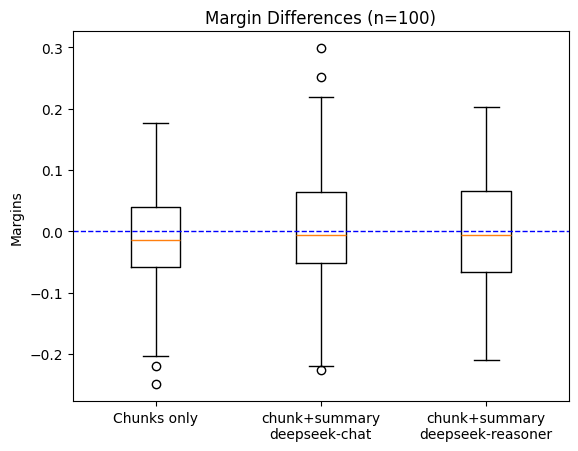

In [66]:
import matplotlib.pyplot as plt

# Load pickle files
# margins_v1 = pd.read_pickle("margins_v1_n100.pkl")
# margins_reasoner_v3 = pd.read_pickle("margins_prompt3_reasoner_n100.pkl")
# margins_chat_v3 = pd.read_pickle("margins_prompt3_chat_n100.pkl")
baseline = pd.read_pickle("margins_chunks_n100.pkl")
chat = pd.read_pickle("margins_chunksum_chat_n100.pkl")
reasoner = pd.read_pickle("margins_chunksum_reasoner_n100.pkl")

plt.boxplot(
    [
        baseline,
        chat,
        reasoner,
    ],
    labels=["Chunks only", "chunk+summary\ndeepseek-chat", "chunk+summary\ndeepseek-reasoner"],
)
plt.axhline(y=0, color="blue", linestyle="--", linewidth=1.0)
plt.title(f"Margin Differences (n={len(sample)})")
plt.ylabel("Margins")
plt.show()

In [ ]:
for stat, num in margins_chat_v3.describe().items():
    print(round(num,4))